# Should I stay or should I go?
## Or: What's the probability to get a new first down?

# Business Understanding

As Headcoach of an American Football team it's importand to decide whether to go on 4th down or not. Depending on the yards to go and field position (and many more variables such as time and current score) the HC has to decide.

In the following I try to answer the following questions:

* Can I predict if a team will reach a new first down in the next play given quarter, time left in quarter, current down, yards to go, position on field?
* Can I give a probability for reaching the first down?
* Is there a difference between the teams on offense?

Further question could be:

* Combining the play by play data to data about a drive: What's the possibily to score a touchdown / field goal given the starting position on the field?
* Again: Is there a preferred QB for 2-minute drives?
* How does the data change from season to season?

# Data Understanding

At Kaggle I found a data set with every play of the NFL season 2015. https://www.kaggle.com/maxhorowitz/nflplaybyplay2015

So let's take a look at it.


In [2]:
# Import all the packages required
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, f1_score

In [4]:
# Read the data and show the first rows
try:
    data = pd.read_csv("data/NFLPlaybyPlay2015.csv", low_memory=False)
except:
    print("Please download the data from Kaggle. For more information please read the Readme.md.")
print(data.shape)
data.head(30)

Please download the data from Kaggle. For more information please read the Readme.md.
(46129, 66)


,Unnamed: 0,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,yrdln,yrdline100,ydstogo,ydsnet,GoalToGo,FirstDown,posteam,DefensiveTeam,desc,PlayAttempted,Yards.Gained,sp,Touchdown,ExPointResult,TwoPointConv,DefTwoPoint,Safety,PuntResult,PlayType,Passer,PassAttempt,PassOutcome,PassLength,PassLocation,InterceptionThrown,Interceptor,Rusher,RushAttempt,RunLocation,RunGap,Receiver,Reception,ReturnResult,Returner,BlockingPlayer,Tackler1,Tackler2,FieldGoalResult,FieldGoalDistance,Fumble,RecFumbTeam,RecFumbPlayer,Sack,Challenge.Replay,ChalReplayResult,Accepted.Penalty,PenalizedTeam,PenaltyType,PenalizedPlayer,Penalty.Yards,PosTeamScore,DefTeamScore,ScoreDiff,AbsScoreDiff,Season
0,36,2015-09-10,2015091000,1,1,NaN,15:00,15,3600.0,0.0,NE,35.0,35.0,0,0,0.0,NaN,PIT,NE,S.Gostkowski kicks 65 yards from NE 35 to end ...,1,0,0,0,NaN,NaN,NaN,0,NaN,Kickoff,NaN,0,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,Touchback,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015
1,51,2015-09-10,2015091000,1,1,1.0,15:00,15,3600.0,0.0,PIT,20.0,80.0,10,18,0.0,1.0,PIT,NE,(15:00) De.Williams right tackle to PIT 38 for...,1,18,0,0,NaN,NaN,NaN,0,NaN,Run,NaN,0,NaN,NaN,NaN,0,NaN,D.Hightower,1,right,tackle,NaN,0,NaN,NaN,NaN,D.Hightower,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015
2,72,2015-09-10,2015091000,1,1,1.0,14:21,15,3561.0,39.0,PIT,38.0,62.0,10,31,0.0,0.0,PIT,NE,(14:21) B.Roethlisberger pass short right to A...,1,9,0,0,NaN,NaN,NaN,0,NaN,Pass,B.Roethlisberger,1,Complete,Short,right,0,NaN,NaN,0,NaN,NaN,A.Brown,1,NaN,NaN,NaN,D.Hightower,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015
3,101,2015-09-10,2015091000,1,1,2.0,14:04,15,3544.0,17.0,PIT,47.0,53.0,1,31,0.0,1.0,PIT,NE,(14:04) De.Williams right guard to NE 49 for 4...,1,4,0,0,NaN,NaN,NaN,0,NaN,Run,NaN,0,NaN,NaN,NaN,0,NaN,J.Collins,1,right,guard,NaN,0,NaN,NaN,NaN,J.Collins,M.Brown,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015
4,122,2015-09-10,2015091000,1,1,1.0,13:26,14,3506.0,38.0,NE,49.0,49.0,10,45,0.0,1.0,PIT,NE,(13:26) B.Roethlisberger pass short right to H...,1,14,0,0,NaN,NaN,NaN,0,NaN,Pass,B.Roethlisberger,1,Complete,Short,right,0,NaN,NaN,0,NaN,NaN,H.Miller,1,NaN,NaN,NaN,J.Mayo,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015
5,159,2015-09-10,2015091000,1,1,1.0,12:42,13,3462.0,44.0,NE,35.0,35.0,10,56,0.0,1.0,PIT,NE,(12:42) (Shotgun) De.Williams right guard to N...,1,11,0,0,NaN,NaN,NaN,0,NaN,Run,NaN,0,NaN,NaN,NaN,0,NaN,J.Collins,1,right,guard,NaN,0,NaN,NaN,NaN,J.Collins,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015
6,180,2015-09-10,2015091000,1,1,1.0,12:05,13,3425.0,37.0,NE,24.0,24.0,10,48,0.0,0.0,PIT,NE,(12:05) A.Brown sacked at NE 32 for -8 yards (...,1,-8,0,0,NaN,NaN,NaN,0,NaN,Sack,NaN,0,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,M.Brown,NaN,NaN,NaN,0,NaN,NaN,1,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015
7,199,2015-09-10,2015091000,1,1,2.0,11:20,12,3380.0,45.0,NE,32.0,32.0,18,54,0.0,0.0,PIT,NE,(11:20) (Shotgun) De.Williams right end pushed...,1,4,0,0,NaN,NaN,NaN,0,NaN,No Play,NaN,0,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,D.Hightower,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,1,PIT,NaN,M.Gilbert,10,0.0,0.0,0.0,0.0,2015
8,236,2015-09-10,2015091000,1,1,2.0,10:53,11,3353.0,27.0,NE,42.0,42.0,28,54,0.0,0.0,PIT,NE,(10:53) W.Johnson right guard to NE 36 for 6 y...,1,6,0,0,NaN,NaN,NaN,0,NaN,Run,NaN,0,NaN,NaN,NaN,0,NaN,W.Johnson,1,right,guard,NaN,0,NaN,NaN,NaN,R.Ninkovich,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015
9,261,2015-09-10,2015091000,1,1,3.0,10:28,11,3328.0,25.0,NE,36.0,36.0,22,54,0.0,0.0,PIT,NE,(10:28) (Shotgun) B.Roethlisberger pass short ...,1,10,0,0,NaN,NaN,NaN,0,NaN,Pass,B.Roethlisberger,1,Complete,Short,right,0,NaN,NaN,0,NaN,NaN,H.Miller,1,NaN,NaN,NaN,P.Chung,M.Butler,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015


In [3]:
data.dtypes

Unnamed: 0             int64
Date                  object
GameID                 int64
Drive                  int64
qtr                    int64
down                 float64
time                  object
TimeUnder              int64
TimeSecs             float64
PlayTimeDiff         float64
SideofField           object
yrdln                float64
yrdline100           float64
ydstogo                int64
ydsnet                 int64
GoalToGo             float64
FirstDown            float64
posteam               object
DefensiveTeam         object
desc                  object
PlayAttempted          int64
Yards.Gained           int64
sp                     int64
Touchdown              int64
ExPointResult         object
TwoPointConv          object
DefTwoPoint           object
Safety                 int64
PuntResult            object
PlayType              object
                      ...   
Interceptor           object
Rusher                object
RushAttempt            int64
RunLocation   

There are many fields describing each play in NFL Season of 2015.
I think the following fields I can use to answer the questions.

In [4]:
# Select only the columns we're interested in. 'FirstDown' is the column we want to predict.
data_small = data[['qtr', 'down', 'TimeSecs', 'yrdline100', 'ydstogo', 'PlayType', 'FirstDown']].copy()
data_small.head(10)

,qtr,down,TimeSecs,yrdline100,ydstogo,PlayType,FirstDown
0,1,NaN,3600.0,35.0,0,Kickoff,NaN
1,1,1.0,3600.0,80.0,10,Run,1.0
2,1,1.0,3561.0,62.0,10,Pass,0.0
3,1,2.0,3544.0,53.0,1,Run,1.0
4,1,1.0,3506.0,49.0,10,Pass,1.0
5,1,1.0,3462.0,35.0,10,Run,1.0
6,1,1.0,3425.0,24.0,10,Sack,0.0
7,1,2.0,3380.0,32.0,18,No Play,0.0
8,1,2.0,3353.0,42.0,28,Run,0.0
9,1,3.0,3328.0,36.0,22,Pass,0.0


# Prepare Data
## Missing values

Checking if there are any missing values:

In [5]:
# As we can see there are some NaN-values. 
# So let's check them
data_small.isna().mean()

qtr           0.000000
down          0.154415
TimeSecs      0.000585
yrdline100    0.002341
ydstogo       0.000000
PlayType      0.000000
FirstDown     0.071929
dtype: float64

15% of all rows have a NaN in column 'down'. Let's inspect these rows.

In [6]:
# A lot of NaNs in column 'down'.  
# Let's look at them
data_small[data_small['down'].isna()].head(20)

,qtr,down,TimeSecs,yrdline100,ydstogo,PlayType,FirstDown
0,1,NaN,3600.0,35.0,0,Kickoff,NaN
32,1,NaN,2700.0,19.0,0,Quarter End,0.0
41,2,NaN,2471.0,15.0,0,Extra Point,0.0
42,2,NaN,2471.0,35.0,0,Kickoff,NaN
59,2,NaN,2041.0,15.0,0,Extra Point,0.0
60,2,NaN,2041.0,35.0,0,Kickoff,NaN
65,2,NaN,1920.0,21.0,0,Two Minute Warning,NaN
69,2,NaN,1848.0,35.0,0,Timeout,0.0
71,2,NaN,1843.0,35.0,0,Timeout,NaN
74,2,NaN,1813.0,26.0,0,Timeout,0.0


The rows with down == NaN are unusual plays such as kickoff or PAT and timeouts or the ends of a quarter. **So we can ignore them and drop them.**

In [7]:
# Drop rows with down == NaA
data_small.dropna(subset=['down'], axis=0, inplace=True)

In [8]:
data_small.isna().mean()


qtr           0.0
down          0.0
TimeSecs      0.0
yrdline100    0.0
ydstogo       0.0
PlayType      0.0
FirstDown     0.0
dtype: float64

Great! All NaNs removed!

## Categorical variables

Since there are no categorical variables, we don't need to reencode anything.

### Check the distribution of FirstDown

In [9]:
data_small['FirstDown'].value_counts()

0.0    26621
1.0    12385
Name: FirstDown, dtype: int64

#### Define function for upsampling to get 50:50 data

There is an imbalance 2:1 in favor to "no first down". 

So let's build a function to upsample the data, so both classes are even distributed.

In [10]:
def upsample_data(data):
    """
    Upsample data with FirstDown == 1
    
    Arguments:
    data: DataFrame
    
    Return Upsampled DataFrame
    """
    
    # Get counts for both values of FirstDown
    class_0, class_1 = data['FirstDown'].value_counts()

    # Split data
    data_class_0 = data[data['FirstDown'] == 0]
    data_class_1 = data[data['FirstDown'] == 1]    
    
    # Resample
    data_class_1_over = data_class_1.sample(class_0, replace=True)
    
    # Combine 
    data_over = pd.concat([data_class_0, data_class_1_over], axis=0)
    
    return data_over
    

In [11]:
data_small_upsampled = upsample_data(data_small)
data_small_upsampled['FirstDown'].value_counts()

1.0    26621
0.0    26621
Name: FirstDown, dtype: int64

# Data Modelling

First let's try a simple model "Decision Tree".

## Prepare for Prediction
So let's split our data into a training and testing set.

In [12]:
X = data_small_upsampled[['qtr', 'down', 'TimeSecs', 'yrdline100', 'ydstogo']]
y = data_small_upsampled['FirstDown']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Using a simple Decision Tree as model.

In [13]:
# Get a model and train it
mdl = DecisionTreeClassifier()
mdl.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

How's the model doing on the training set?

In [14]:
y_pred = mdl.predict(X_train)
acc = accuracy_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
print("The accuracy on the training data was {}.".format(acc))
print("The f1_score on the training data was {}.".format(f1))

The accuracy on the training data was 0.9920946400538238.
The f1_score on the training data was 0.992113652888864.


Wow, that's great!
But what about the testing data?


In [15]:
y_pred = mdl.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("The accuracy on the testing data was {}.".format(acc))
print("The f1_score on the testing data was {}.".format(f1))

The accuracy on the testing data was 0.7978372225384177.
The f1_score on the testing data was 0.812242308912147.


Okay, 79% accuracy that's not bad. But we can see the model did overfitting.
Let's try another model.

## Trying other models

First we'll define a function we can pass the data and the model.

In [16]:
def score_by_model(data, model):
    """
    Split data and do a prediction with model. Than print out the accuracy on training and testing data.
    
    Arguments:
    data - DataFrame with the data. The last column contains the data which should be predicted.
    model - A classification model which is used for the prediction.
    
    Result: 
    returns the fitted model
    """
    
    # Upsample data
    data = upsample_data(data)
    
    # Get X and y from the data
    X = data.iloc[:, :-1]
    y = data[data.columns[-1]]
    
    # Split the data in training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Accuracy on training data
    y_pred = model.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    print("The accuracy on the training data was {}.".format(acc))
    print("The f1_score on the training data was {}.".format(f1))
    
    # Accuracy on testing dat
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)    
    print("The accuracy on the testing data was {}.".format(acc))
    print("The f1_score on the testing data was {}.".format(f1))
    
    return model

In [17]:
# Test the function with DecisionTreeClassifier
mdl = DecisionTreeClassifier()

# Drop column 'PlayType'
data_to_train = data_small.drop(columns=['PlayType'])

mdl_decision_tree = score_by_model(data_to_train, mdl)

The accuracy on the training data was 0.9927674366449877.
The f1_score on the training data was 0.9927856383871149.
The accuracy on the testing data was 0.7927717700626067.
The f1_score on the testing data was 0.8063194850789935.


In [18]:
# Test the function with RandomForrest
mdl = RandomForestClassifier(n_estimators=20)

# Drop column 'PlayType'
data_to_train = data_small.drop(columns=['PlayType'])

mdl_random_forrest = score_by_model(data_to_train, mdl)

The accuracy on the training data was 0.9885344247589145.
The f1_score on the training data was 0.9885296014807752.
The accuracy on the testing data was 0.8101878201479795.
The f1_score on the testing data was 0.8185823859000164.


Better, but still overfitting.

In [19]:
# Test the function with LogisticRegression
mdl = LogisticRegression(solver='lbfgs')

# Drop column 'PlayType'
data_to_train = data_small.drop(columns=['PlayType'])

mdl_logistic_regression = score_by_model(data_to_train, mdl)

The accuracy on the training data was 0.6300459744337296.
The f1_score on the training data was 0.6177552498189718.
The accuracy on the testing data was 0.6354581673306773.
The f1_score on the testing data was 0.6260727421332244.


Oh, that's worse. So we'll use RandomForest.

# Evaluate the Results

The best model we've found is the RandomForest-Model. It performs very well regarding accuracy and f1_score.

So let's use it and answer the questions of interest.

## Predictions
So let's try some predictions for some situations:

* The first row is the first play of a game: Own 20-yard line, 1st and 10.
* The second row is 20 seconds to play in the game, 15-yard line in the redzone, 4th and 10.

In [20]:
data_fantasy = pd.DataFrame({'qtr': [1, 4], 'down': [1, 4], 'TimeSecs': [3600, 20], 'yrdline100': [80, 15],\
                            'ydstogo': [10, 10]})
data_fantasy

,qtr,down,TimeSecs,yrdline100,ydstogo
0,1,1,3600,80,10
1,4,4,20,15,10


So what are the predictions?

In [21]:
mdl_random_forrest.predict(data_fantasy)

array([0., 0.])

In the first play we won't get a new first down, in the second we won't get it, too!

## Probabilities
But what are the probabilities?

In [22]:
mdl_random_forrest.predict_proba(data_fantasy)[:, 1]

array([0.42573727, 0.45      ])

In the first case we will get the first down in 37%, in the second case in 30% -- the model says ;-)

### How do the probality change in respect to the position on the field?

We create a dataframe for 3rd and 4 at mid-quarter for each yardline on the field. 

In [23]:
qtr = np.full(99, 2)
down = np.full(99, 3)
TimeSecs = np.full(99, 1800)
yrdline100 = np.arange(1, 100, 1)
ydstogo = np.full(99, 4)

data_fantasy = pd.DataFrame({'qtr': qtr, 'down': down, 'TimeSecs': TimeSecs, 'yrdline100': yrdline100,\
                            'ydstogo': ydstogo})
data_fantasy.head()

,qtr,down,TimeSecs,yrdline100,ydstogo
0,2,3,1800,1,4
1,2,3,1800,2,4
2,2,3,1800,3,4
3,2,3,1800,4,4
4,2,3,1800,5,4


In [24]:
# Predict probabilities
probs = mdl_random_forrest.predict_proba(data_fantasy)[:, 1]
probs

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.05, 0.05, 0.15, 0.45, 0.3 ,
       0.1 , 0.25, 0.3 , 0.2 , 0.1 , 0.2 , 0.5 , 0.25, 0.2 , 0.2 , 0.3 ,
       0.15, 0.3 , 0.4 , 0.2 , 0.25, 0.35, 0.35, 0.35, 0.25, 0.15, 0.3 ,
       0.1 , 0.2 , 0.2 , 0.15, 0.15, 0.1 , 0.15, 0.45, 0.35, 0.35, 0.35,
       0.3 , 0.25, 0.35, 0.35, 0.25, 0.3 , 0.3 , 0.3 , 0.25, 0.2 , 0.15,
       0.15, 0.15, 0.15, 0.05, 0.15, 0.15, 0.15, 0.15, 0.15, 0.1 , 0.05,
       0.05, 0.15, 0.25, 0.3 , 0.45, 0.45, 0.45, 0.55, 0.35, 0.55, 0.6 ,
       0.5 , 0.2 , 0.1 , 0.4 , 0.25, 0.2 , 0.05, 0.1 , 0.1 , 0.1 , 0.1 ,
       0.25, 0.1 , 0.05, 0.1 , 0.15, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

[Text(0, 0.5, 'Probability'), Text(0.5, 0, 'Fieldposition yardline')]

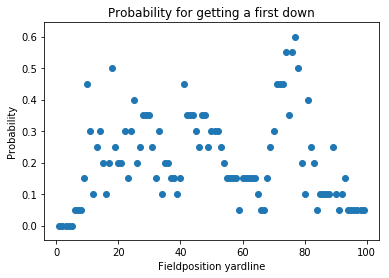

In [25]:
fig, ax = plt.subplots()
ax.scatter(data_fantasy['yrdline100'], probs)
ax.set_title('Probability for getting a first down')
ax.set(xlabel='Fieldposition yardline', ylabel='Probability')

At your own endzone it's hard to get a first down. In midfield it's way easier. But it gets harder if you come to your opponents endzone.

## What about different teams?

So let's the select additional the team in offense.

In [26]:
# Select only the columns we're interested in. 'FirstDown' is the column we want to predict.
data_with_team = data[['qtr', 'down', 'TimeSecs', 'yrdline100', 'ydstogo', 'posteam', 'FirstDown']].copy()
# Drop rows with down == NaA
data_with_team.dropna(subset=['down'], axis=0, inplace=True)
data_with_team.head()

,qtr,down,TimeSecs,yrdline100,ydstogo,posteam,FirstDown
1,1,1.0,3600.0,80.0,10,PIT,1.0
2,1,1.0,3561.0,62.0,10,PIT,0.0
3,1,2.0,3544.0,53.0,1,PIT,1.0
4,1,1.0,3506.0,49.0,10,PIT,1.0
5,1,1.0,3462.0,35.0,10,PIT,1.0


## Categorical Variables

The column "posteam" is a categorical variable. If we want to use it in one model we have to reencode it with 1-hot-encoding.

Instead of this way we generate 30 different models, one for each team. We split the data in 30 parts and drop the categorical variable after splitting.

Doing so it's easier to predict 'FirstDown' for one given team.


In [27]:
teams = pd.unique(data_with_team['posteam'])
models = {}
for team in teams:
    print("Processing team {}".format(team))
    mdl = RandomForestClassifier(n_estimators=20)
    # Get only the data of the specified team
    data_with_single_team = data_with_team[data_with_team['posteam'] == team].copy()

    # Drop column 'posteam'
    data_with_single_team.drop(columns=['posteam'], axis=1, inplace=True)
    
    # Train model
    mdl_logistic_regression_team = score_by_model(data_with_single_team, mdl)
    models[team] = mdl_logistic_regression_team

Processing team PIT
The accuracy on the training data was 0.9918330308529946.
The f1_score on the training data was 0.9918404351767907.
The accuracy on the testing data was 0.8235294117647058.
The f1_score on the testing data was 0.8378378378378377.
Processing team NE
The accuracy on the training data was 0.992153443766347.
The f1_score on the training data was 0.9921121822962313.
The accuracy on the testing data was 0.8584070796460177.
The f1_score on the testing data was 0.8611111111111112.
Processing team CHI
The accuracy on the training data was 0.9964444444444445.
The f1_score on the training data was 0.996415770609319.
The accuracy on the testing data was 0.8666666666666667.
The f1_score on the testing data was 0.8701754385964913.
Processing team GB
The accuracy on the training data was 0.9966749792186201.
The f1_score on the training data was 0.9966722129783694.
The accuracy on the testing data was 0.8330522765598651.
The f1_score on the testing data was 0.845553822152886.
Proce

### Show four different teams

Denver (12-4) beat Carolina (15-1) in SuperBowl 50 (https://en.wikipedia.org/wiki/2015_NFL_season)
So we compare these two teams against the two worst teams Tennessee and Cleveland (both 3-13)

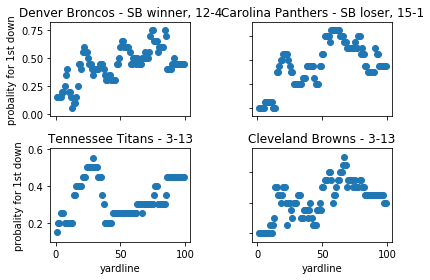

In [28]:
fig, axs = plt.subplots(2, 2)

probs = models['DEN'].predict_proba(data_fantasy)[:, 1]
axs[0,0].scatter(data_fantasy['yrdline100'], probs)
axs[0,0].set_title('Denver Broncos - SB winner, 12-4')

probs = models['CAR'].predict_proba(data_fantasy)[:, 1]
axs[0,1].scatter(data_fantasy['yrdline100'], probs)
axs[0,1].set_title('Carolina Panthers - SB loser, 15-1')

probs = models['TEN'].predict_proba(data_fantasy)[:, 1]
axs[1,0].scatter(data_fantasy['yrdline100'], probs)
axs[1,0].set_title('Tennessee Titans - 3-13')

probs = models['CLE'].predict_proba(data_fantasy)[:, 1]
axs[1,1].scatter(data_fantasy['yrdline100'], probs)
axs[1,1].set_title('Cleveland Browns - 3-13')


for ax in axs.flat:
    ax.set(xlabel='yardline', ylabel='probality for 1st down')
    
for ax in fig.get_axes():
    ax.label_outer()
    
plt.tight_layout()

As you can see both SuperBowl teams have higher probabilities than the bad teams. 

Getting first downs helps winning championships!